# Working with map projections

In Chapter 5, we learned that the Coordinate Reference System (CRS) describes how geometries are related to the places on Earth and what are the core components of a CRS. Our main tool for managing coordinate reference systems is the [PROJ library](https://proj.org/) [^proj] which can be used through the [pyproj](https://pyproj4.github.io/pyproj/stable/) [^pyproj] Python library. Pyproj is bundled into geopandas and it can be used to access the CRS information of a given geographic dataset and also for reprojecting the data from one coordinate system to another. In the following, we will demonstrate how to work with coordinate reference systems in geopandas by using a country border dataset from Europe. We will reproject the dataset from the original WGS84 coordinate system into a Lambert Azimuthal Equal Area projection which is the projection that European Union [recommends for Europe](http://mapref.org/LinkedDocuments/MapProjectionsForEurope-EUR-20120.pdf) [^EU_projection].

Let's start by reading the data from the `eu_countries_2022.gpkg` file. When reading the data into `GeoDataFrame` with `geopandas`, the CRS information is automatically read from the datafile and stored into the `.crs` attribute:

In [1]:
import geopandas as gpd

# Read the file
fp = "data/EU_countries/eu_countries_2022.gpkg"
data = gpd.read_file(fp)

# What is the type?
print(type(data.crs))

# Check the coordinate reference system information
data.crs

<class 'pyproj.crs.crs.CRS'>


<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

What geopandas returns here is in fact a `CRS` object from the pyproj library. The EPSG code of our data is `4326` which refers to the WGS84 coordinate system. You will encounter this EPSG-code frequenctly in the geospatial world as it is perhaps the most commonly used coordinate reference system in the world. As we learned earlier, the EPSG number is an identification code that tells which is the coordinate system of a given dataset. In this case, we could also guess the probable CRS by looking at the coordinates values in the `geometry` column which are longitude and latitudes decimal degrees:

In [2]:
data["geometry"].head()

0    MULTIPOLYGON (((13.684 46.4375, 13.511 46.3484...
1    MULTIPOLYGON (((6.3156 50.497, 6.405 50.3233, ...
2    MULTIPOLYGON (((28.498 43.4341, 28.0602 43.316...
3    MULTIPOLYGON (((16.9498 48.5358, 16.8511 48.43...
4    MULTIPOLYGON (((32.9417 34.6418, 32.559 34.687...
Name: geometry, dtype: geometry

As we can see, the coordinate values of the MultiPolygons here vary between 6-50 (approximately). Hence, our geometries very much look like {term}`decimal degrees` because all the coordinate values (such as `13.68400 46.43750`) are within the range of -180 to +180 (longitude) and -90 to +90 (latitude). WGS84 is one of the most typical CRS to use with datasets that cover data from different parts of the world. However, WGS84 is not really a good coordinate system for representing European borders on a map because the areas get distorted. Hence, it is a good idea to convert these geometries into [Lambert Azimuthal Equal Area projection](http://spatialreference.org/ref/epsg/etrs89-etrs-laea/) [^LAEA] (EPSG:3035) which is a good option for creating maps with country-level data in Europe.

## Reprojecting a GeoDataFrame

Changing from one coordinate system to another is one of the most common tasks to do when working with geographic data. This process is commonly called as {term}`map reprojection`, {term}`coordinate transformation` or {term}`geographic coordinate conversion`. When the data is reprojected, the coordinates described in one CRS transformed to another CRS by using specific geodetic equations. Knowing how to transform coordinates is important because different coordinate systems are used for different purposes, and it is often necessary to reproject some data to make them interoparable and comparable. For example, coordinates on the Earth's surface may be represented in geographic (latitude and longitude) or projected (Cartesian) coordinates, and the same location will have different coordinate values depending on the CRS used. It is important that the layers are in the same coordinate system when analyzing the spatial relationships between the layers, such as when making a Point in Polygon -query, or other types of overlay analysis. The transformation between the coordinate systems involves both translation and rotation, and requires knowledge of the shape and size of the Earth, as well as its orientation in space.

Reprojecting geographic data from one coordinate system to another might sound a bit tricky, but luckily we do not need to define any equations ourselves. In geopandas, the `.to_crs()` -method of a `GeoDataFrame` will perform coordinate transformations with given parameters. The method has two alternative parameters: 1) `crs` which accepts CRS information from various formats, such as proj-strings or OGS WKT text; and 2) `epgs` that accepts the EPSG-code of a given coordinate system as a number. Both of these can be used to make the coordinate transformation and reproject the data into a desired CRS. Let's try it out and reproject our data into `EPSG:3035` using the `epsg` -parameter:

In [3]:
# Let's make a backup copy of our data
data_wgs84 = data.copy()

# Reproject the data
data = data.to_crs(epsg=3035)

# Check the new geometry values
data["geometry"].head()

0    MULTIPOLYGON (((4604288.477 2598607.47, 459144...
1    MULTIPOLYGON (((4059689.242 3049361.18, 406508...
2    MULTIPOLYGON (((5805367.757 2442801.252, 57739...
3    MULTIPOLYGON (((4833567.363 2848881.974, 48272...
4    MULTIPOLYGON (((6413299.362 1602181.345, 63782...
Name: geometry, dtype: geometry

In [4]:
# Checkthe new EPSG code
data.crs.to_epsg()

3035

And here we go, the coordinate values in the geometries have changed! Now we have successfully changed the CRS of our layer into a new one, i.e. to the planar `ETRS-LAEA` coordinate system (EPSG:3035). To really understand what is going on we can explore the result visually by plotting the original and reprojected data side-to-side. 

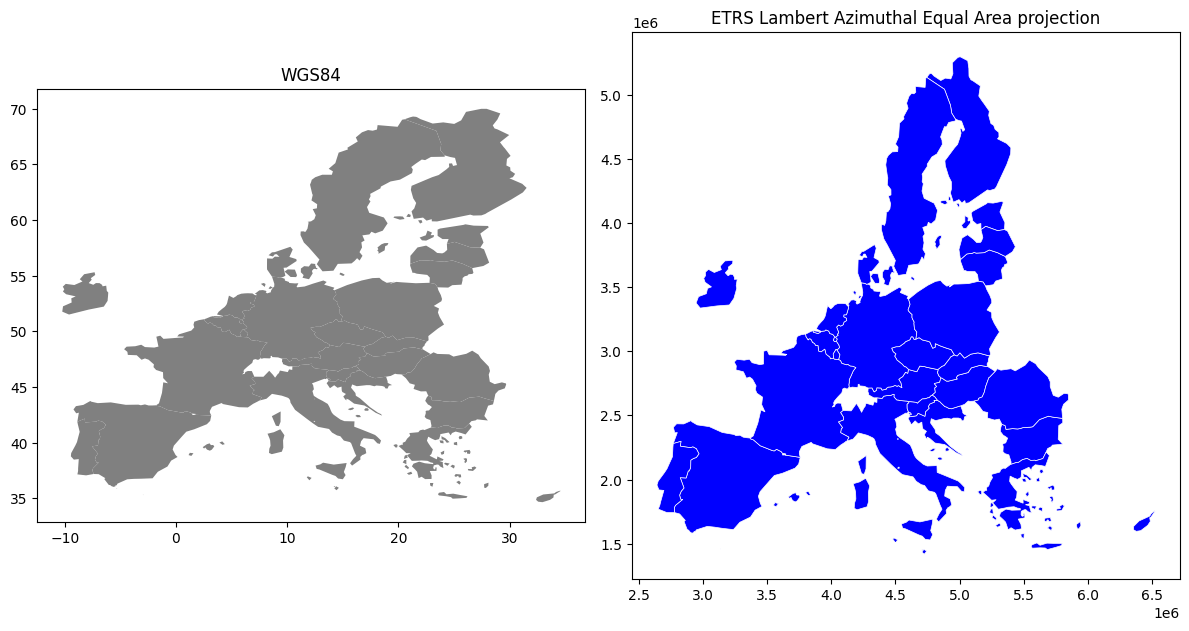

In [5]:
import matplotlib.pyplot as plt

# Make subplots that are next to each other
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 12))

# Plot the data in WGS84 CRS
data_wgs84.plot(ax=ax1, facecolor="gray")

# Plot the one with ETRS-LAEA projection
data.plot(ax=ax2, facecolor="blue", edgecolor="white", lw=0.5)

# Add titles
ax1.set_title("WGS84")
ax2.set_title("ETRS Lambert Azimuthal Equal Area projection")

# Set aspect ratio as 1
ax1.set_aspect(aspect=1)
ax2.set_aspect(aspect=1)

# Remove empty white space around the plot
plt.tight_layout()

_**Figure 6.26**. Map of Europe plotted with two different coordinate reference systems._

As we can see from the **Figure 6.26**, the maps look quite different and the reprojected one looks significantly better especially in the North where the geometries are more realistic and not so stretched as in WGS84. Finally, let's save our projected layer into a Shapefile so that we can use it later. Note, even if the CRS information is stored with the output file (in this case into a `.prj` file associated with the Shapefile), it might be a good idea also to include CRS info in the filename which makes it easy to identify the CRS directly from the name of the file:

In [6]:
# Ouput filepath
outfp = "data/EU_countries/Europe_borders_epsg3035.shp"

# Save to disk
data.to_file(outfp)

#### Question 6.6

One of the recommended coordinate reference systems for Finland is [ETRS89 / TM35FIN (EPSG:3067)](https://spatialreference.org/ref/epsg/3067/) [^EPSG3067]

First, select Finland from our dataset of EU countries. Then, plot two maps of Finland where you compare the WGS84 (EPSG:4326) representation and ETRS89 / TM35FIN (EPSG:3067). You can achieve this by modifying the previous example for the whole EU. 

In [7]:
# Use this cell to enter your solution.

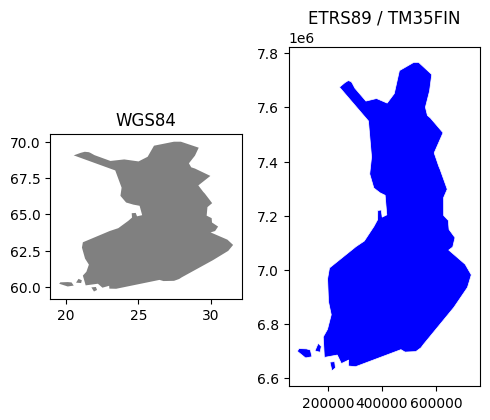

In [8]:
# Solution

# Select Finland and reproject
finland_wgs84 = data_wgs84.loc[data_wgs84["NAME_ENGL"] == "Finland"].copy()
finland_etrs89 = finland_wgs84.to_crs(epsg=3067)

# Make subplots that are next to each other
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(5, 5))

# Plot the data in WGS84 CRS
finland_wgs84.plot(ax=ax1, facecolor="gray")

# Plot the one with ETRS-LAEA projection
finland_etrs89.plot(ax=ax2, facecolor="blue", edgecolor="white", lw=0.5)

# Add titles
ax1.set_title("WGS84")
ax2.set_title("ETRS89 / TM35FIN")

# Set aspect ratio as 1
ax1.set_aspect(aspect=1)
ax2.set_aspect(aspect=1)

# Remove empty white space around the plot
plt.tight_layout()

## Parsing Coordinate Reference System characteristics

You will likely encounter many different coordinate reference systems when working with geographic data obtained from different sources. Being able to define CRS information from scratch for a given dataset is needed every now and then, and in the following we show a few useful tricks to work with different coordinate systems using the pyproj library. In the previous section, we saw how geopandas uses the `pyproj.CRS` object to store the coordinate reference system information. In fact, this same library provides many useful functionalities for dealing with CRS information, and we can use the `CRS` object/class to for example easily parse, define and convert CRS information. In the following, we import the `CRS` class from the pyproj library and initialize a specific coordinate reference system using the `.from_epsg()` method and `EPSG` code as input:

In [9]:
from pyproj import CRS

crs_object = CRS.from_epsg(3035)

As you can see, it is very easy to initialize a CRS with a given EPSG code, and in a similar manner you can initialize hundreds of other coordinate reference systems by changing this code. The resulting CRS object (here stored in variable `crs_object`) contains a lot of information about the coordinate reference system such as the `Name` of the CRS (ETRS89/LAEA Europe), the `Axis Info` of the coordinate system (ellipsoidal or cartesian), the `Area of Use` where the given CRS is in use (Europe with bounds `(-35.58, 24.6, 44.83, 84.73)`), as well as the `Datum` (European Terrestrial Reference System 1989). You could output all of this information by typing `crs_object` in a code cell, but we can also easily parse this information individually as follows: 

In [10]:
print("Name:", crs_object.name)
print("Coordinate system:", crs_object.coordinate_system)
print("Bounds:", crs_object.area_of_use.bounds)
print("Datum:", crs_object.datum)

Name: ETRS89-extended / LAEA Europe
Coordinate system: cartesian
Bounds: (-35.58, 24.6, 44.83, 84.73)
Datum: European Terrestrial Reference System 1989 ensemble


We can also easily export this CRS information to different formats, such as `WKT` or `Proj4` text, or to EPSG code. For this, we can use the `CRS` class methods, such as `.to_wkt()`, `.to_proj4()` and `.to_epsg()` accordingly. You can explore all the possible information that can be extracted (and exported) from the CRS by typing `crs_object.` and pressing <kbd>Tab</kbd>. In the following, we export the CRS information to WKT format: 

In [11]:
crs_wkt = crs_object.to_wkt()

The `WKT` format contains a *lot* of information. If we were to run `print(crs_wkt)` we would see output like that below (truncated to save space):
```
PROJCRS["ETRS89-extended / LAEA Europe",BASEGEOGCRS["ETRS89",ENSEMBLE["European
Terrestrial Reference System 1989 ensemble",MEMBER["European Terrestrial Referen
ce Frame 1989"],MEMBER["European Terrestrial Reference Frame 1990"],MEMBER["Euro
pean Terrestrial Reference Frame 1991"],MEMBER["European Terrestrial Reference F
rame 1992"],MEMBER["European Terrestrial Reference Frame 1993"],MEMBER["European
 Terrestrial Reference Frame 1994"],MEMBER["European Terrestrial Reference Frame
 1996"],MEMBER["European Terrestrial Reference Frame 1997"],MEMBER["European Ter
restrial Reference Frame 2000"],MEMBER["European Terrestrial Reference Frame 200
5"],MEMBER["European Terrestrial Reference Frame 2014"],ELLIPSOID["GRS 1980",637
...
```
Typically, e.g. the `.prj` file of a Shapefile contains the information in this format. Let's see how it is possible to extract `EPSG` code from this. For doing it, we first re-initialize the CRS object from the `WKT` text presentation, and then parse the EPSG code from the CRS:   

In [12]:
# Retrieve EPSG code from WKT text
epsg = CRS(crs_wkt).to_epsg()
print(epsg)

3035


Sometimes `.to_epsg()` isn't able to recognize the EPSG code from the WKT representation. This can happen if the WKT information is missing some details. Luckily, we can easily adjust the minimum level of confidence for matching the CRS info and the EPSG code. We can do this by adjusting a parameter `min_confidence` when calling the function. By default, the confidence level is 70 %, but it is also possible to set a lower confidence threshold, e.g. by specifying `min_confidence=25`:

In [13]:
CRS(crs_wkt).to_epsg(min_confidence=25)

3035

## Defining CRS for a GeoDataFrame

One of the common situations when you need to define a CRS for your data is when creating a new GeoDataFrame from scratch. In the following, we first create a new GeoDataFrame with a single point without specifying the CRS: 

In [14]:
from shapely.geometry import Point

# Create GeoDataFrame with one point
gdf = gpd.GeoDataFrame({"geometry": Point(24.950899, 60.169158)}, index=[0])
print(gdf.crs)

None


As we see, the `GeoDataFrame` does not have CRS specified at this stage which is a problem, because the GIS systems cannot work with this kind of dataset. The coordinates for our point are represented in decimal degrees, hence the CRS of our `GeoDataFrame` should be WGS84. We can define the CRS for our data in a few different ways, but one of the approaches is to use the `CRS.from_epsg()` method from the pyproj library, and store the information to the `.crs` attibute of the `GeoDataFrame`:

In [15]:
from pyproj import CRS

gdf.crs = CRS.from_epsg(4326)
gdf.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

As we can see, now the `.crs` attribute was updated with information about the coordinate reference system and we can for example reproject the data to another CRS if needed. Without a defined CRS, you cannot reproject the data.  You can also specify the CRS for a given `GeoDataFrame` by using `.set_crs()` method: 

In [16]:
gdf = gdf.set_crs(epsg=4326)
print(gdf.crs)

EPSG:4326


Naturally, you do not necessarily need to define the CRS separately after creating the `GeoDataFrame`, but you can actually provide the CRS information with the `crs` parameter when creating the dataset as follows:

In [17]:
# Create GeoDataFrame with one point and define the CRS
gdf = gpd.GeoDataFrame(
    {"geometry": Point(24.950899, 60.169158)}, index=[0], crs="EPSG:4326"
)
gdf.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

As you can see, now the dataset contains the CRS information immediately after the dataset was created. You can pass the CRS information for the `crs` parameter in various formats (e.g. as EPSG number, Proj4 or WKT text) and pyproj / geopandas libraries try to automatically set the CRS information for the data.  

## Defining different map projections

Finally, let's play around with global map projections to show a few different map projections and how to define them. In this example, we use a global country border dataset obtained from Natural Earth [^natural_earth]:

In [18]:
import geopandas

fp = "data/Natural_Earth/ne_110m_admin_0_countries.zip"
admin = gpd.read_file(fp)
admin.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

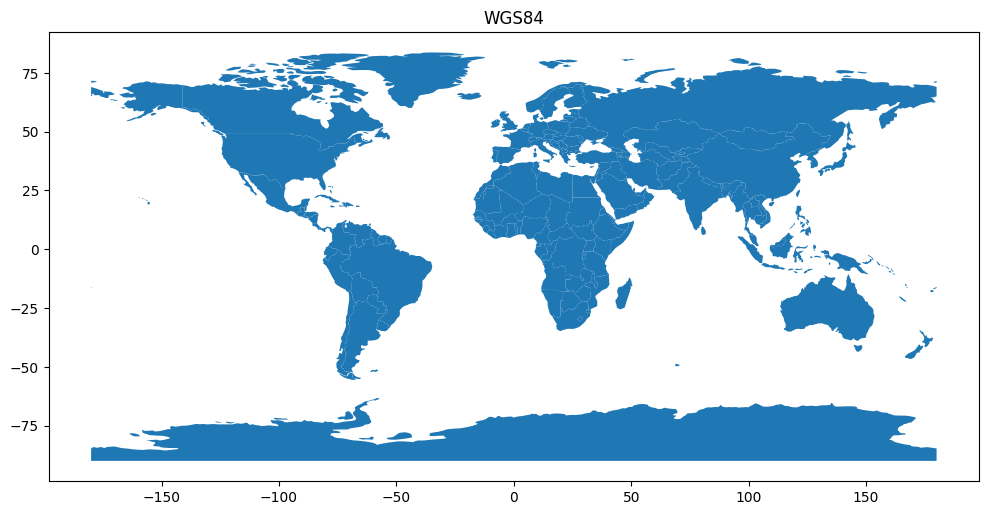

In [19]:
# Plot in original crs
admin.plot(figsize=(12, 6))
plt.title("WGS84");

_**Figure 6.27**. Global map plotted in WGS84 coordinate reference system._

As we can see, the source data is in WGS84 projection which distorts the shape of the countries quite a bit especially in the Northern and Southern parts of the world. We can easily reproject the data into Web Mercator which is widely used in Web mapping applications. We can do this by using the `.to_crs()` method and plotting the result (in this case as an interactive map):

In [20]:
admin.to_crs(epsg=3857).explore()

_**Figure 6.28**. Global map plotted in Web Mercator._

As we can see, the Web Mercator projection also distorts and exaggerates e.g. the size of the Antarctica and Greenland quite significantly. Luckily, there are also better map projections for visualizing global datasets, such as Eckert IV. There isn't a direct EPSG number for Eckert IV, but we can provide the CRS information as an ESRI CRS code `ESRI:54012` as follows:

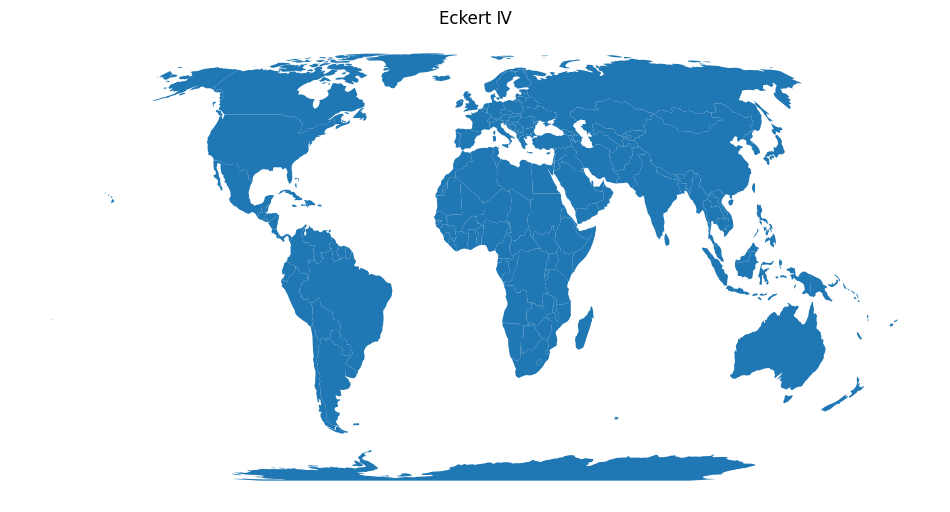

In [21]:
admin.to_crs(crs="ESRI:54012").plot(figsize=(12, 12))
plt.title("Eckert Ⅳ")
plt.axis("off");

_**Figure 6.29**. Global map plotted in Eckert IV._

As the Figure 6.29 shows, the Eckert IV map projection provides a more balanced view of the world with less distortion in the Northern and Southern parts of the world. Lastly, we can also define an Orthographic projection for our map which can be centered to specific point in the world. For doing this, we can specify the CRS using a proj-string and specify the center point with a few of CRS parameters: `+lat`, `+lon` (see [PROJ documentation](https://proj.org/operations/projections/ortho.html) [^Ortho] for details).    

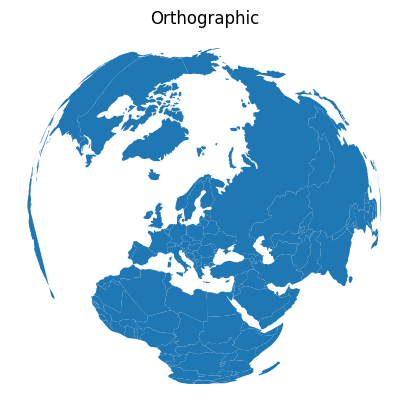

In [22]:
proj_string = "+proj=ortho +lat_0=60.00 +lon_0=24.0000"
ortho = CRS.from_proj4(proj_string)
admin.to_crs(ortho).plot()
plt.axis("off")
plt.title("Orthographic");

_**Figure 6.30**. Global map plotted in an orthographic projection._

As we can see, now we have a nice map centered around Finland that reminds a bit how the world would look from space. 

## Footnotes

[^proj]: <https://proj.org/>
[^pyproj]: <https://pyproj4.github.io/pyproj/stable/>
[^EU_projection]: <http://mapref.org/LinkedDocuments/MapProjectionsForEurope-EUR-20120.pdf>
[^LAEA]: <https://spatialreference.org/ref/epsg/etrs89-etrs-laea/>
[^EPSG3067]: <https://spatialreference.org/ref/epsg/3067/>
[^natural_earth]: <https://www.naturalearthdata.com/downloads/110m-cultural-vectors/>
[^Ortho]: <https://proj.org/operations/projections/ortho.html>